In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import netCDF4

In [2]:
# CF-Compliant ROMS ocean model output
# browse: http://geoport.whoi.edu/thredds/dodsC/examples/bora_feb.nc.html

# DAP URL
#url='http://geoport.whoi.edu/thredds/dodsC/examples/bora_feb.nc'

nc = netCDF4.Dataset('ocean_avg_1161.nc')
mask = nc.variables['mask_rho'][:]

# read longitude, latitude
lon_rho = nc.variables['lon_rho'][:,:]
lat_rho = nc.variables['lat_rho'][:,:]

# read water depth
depth = nc.variables['h'][:,:]

'''
z(n,k,j,i) = eta(n,j,i)*(1+s(k)) + depth_c*s(k) +
             (depth(j,i)-depth_c)*C(k)

  C(k) = (1-b)*sinh(a*s(k))/sinh(a) + 
         b*[tanh(a*(s(k)+0.5))/(2*tanh(0.5*a)) - 0.5]

formula_terms: s: s_rho eta: zeta depth: h a: theta_s b: theta_b depth_c: hc
'''

'\nz(n,k,j,i) = eta(n,j,i)*(1+s(k)) + depth_c*s(k) +\n             (depth(j,i)-depth_c)*C(k)\n\n  C(k) = (1-b)*sinh(a*s(k))/sinh(a) + \n         b*[tanh(a*(s(k)+0.5))/(2*tanh(0.5*a)) - 0.5]\n\nformula_terms: s: s_rho eta: zeta depth: h a: theta_s b: theta_b depth_c: hc\n'

In [3]:
s = nc.variables['s_rho'][:]
a = nc.variables['theta_s'][:]
b = nc.variables['theta_b'][:]
depth_c = nc.variables['hc'][:]

C = (1-b)*np.sinh(a*s)/np.sinh(a) + b*[np.tanh(a*(s+0.5))/(2*np.tanh(0.5*a)) - 0.5]

In [4]:
nc.variables.keys()

dict_keys(['ntimes', 'ndtfast', 'dt', 'dtfast', 'dstart', 'nHIS', 'ndefHIS', 'nRST', 'ntsAVG', 'nAVG', 'ndefAVG', 'Falpha', 'Fbeta', 'Fgamma', 'nl_tnu2', 'nl_visc2', 'LuvSponge', 'LtracerSponge', 'Akt_bak', 'Akv_bak', 'rdrg', 'rdrg2', 'Zob', 'Zos', 'Znudg', 'M2nudg', 'M3nudg', 'Tnudg', 'rho0', 'gamma2', 'LuvSrc', 'LwSrc', 'LtracerSrc', 'LsshCLM', 'Lm2CLM', 'Lm3CLM', 'LtracerCLM', 'LnudgeM2CLM', 'LnudgeM3CLM', 'LnudgeTCLM', 'spherical', 'xl', 'el', 'Vtransform', 'Vstretching', 'theta_s', 'theta_b', 'Tcline', 'hc', 's_rho', 's_w', 'Cs_r', 'Cs_w', 'h', 'f', 'pm', 'pn', 'lon_rho', 'lat_rho', 'lon_u', 'lat_u', 'lon_v', 'lat_v', 'lon_psi', 'lat_psi', 'angle', 'mask_rho', 'mask_u', 'mask_v', 'mask_psi', 'ocean_time', 'zeta', 'ubar', 'vbar', 'u', 'v', 'temp', 'salt'])

In [5]:
print (nc.variables['s_rho'])

<class 'netCDF4._netCDF4.Variable'>
float64 s_rho(s_rho)
    long_name: S-coordinate at RHO-points
    valid_min: -1.0
    valid_max: 0.0
    positive: up
    standard_name: ocean_s_coordinate_g1
    formula_terms: s: s_rho C: Cs_r eta: zeta depth: h depth_c: hc
    field: s_rho, scalar
unlimited dimensions: 
current shape = (40,)
filling on, default _FillValue of 9.969209968386869e+36 used


In [6]:
# Reshape 1D vertical variables so we can broadcast
C.shape = (np.size(C), 1, 1)
s.shape = (np.size(s), 1, 1)

In [7]:
tidx = -1       # just get the final time step, for now.
# read a 3D temperature field at specified time step
temp = nc.variables['temp'][tidx, :, :, :]
# read a 2D water level (height of ocean surface) at specified time step
eta = nc.variables['zeta'][tidx, :, :]
# calculate the 3D field of z values (vertical coordinate) at this time step
z = eta*(1+s) + depth_c*s + (depth-depth_c)*C

In [8]:
(eta*s).shape

(40, 414, 424)

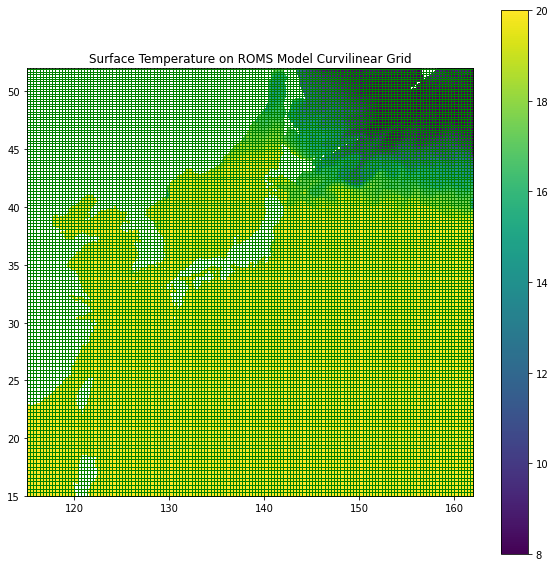

In [9]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,aspect=1.0/np.cos(np.mean(lat_rho.flatten()) * np.pi / 180.0))
pc3 = plt.pcolormesh(lon_rho,lat_rho,temp[-1,:,:], vmin=8, vmax=20)# plot surface temperature
plt.plot(lon_rho[::3,::3],lat_rho[::3,::3],'g+');
plt.plot(lon_rho.T[::3,::3],lat_rho.T[::3,::3],'g+');
plt.title('Surface Temperature on ROMS Model Curvilinear Grid')
plt.colorbar();

In [10]:
lon_rho.shape

(414, 424)

In [11]:
lon3d = np.ones((20,1,1))*lon_rho
lon3d.shape

(20, 414, 424)

In [12]:
lon3d[:,1,1]

masked_array(data=[115.11111111, 115.11111111, 115.11111111, 115.11111111,
                   115.11111111, 115.11111111, 115.11111111, 115.11111111,
                   115.11111111, 115.11111111, 115.11111111, 115.11111111,
                   115.11111111, 115.11111111, 115.11111111, 115.11111111,
                   115.11111111, 115.11111111, 115.11111111, 115.11111111],
             mask=False,
       fill_value=1e+20)

In [13]:
import numpy as np
lon3d=np.ma.getdata(lon3d)
z=np.ma.getdata(z)
temp=np.ma.masked_where(np.isnan(temp),temp)

In [14]:
temp=np.ma.getdata(temp)

In [15]:
lon3d[:,3,2]

array([115.22222222, 115.22222222, 115.22222222, 115.22222222,
       115.22222222, 115.22222222, 115.22222222, 115.22222222,
       115.22222222, 115.22222222, 115.22222222, 115.22222222,
       115.22222222, 115.22222222, 115.22222222, 115.22222222,
       115.22222222, 115.22222222, 115.22222222, 115.22222222])

In [16]:
temp

array([[[1.6254146e+00, 1.6221154e+00, 1.6260952e+00, ...,
         1.0552183e+00, 1.0564412e+00, 1.0566005e+00],
        [1.6287140e+00, 1.6790884e+00, 1.6812670e+00, ...,
         1.0894371e+00, 1.0872766e+00, 1.0567598e+00],
        [1.6367377e+00, 1.7118038e+00, 1.7347623e+00, ...,
         1.0913347e+00, 1.0934052e+00, 1.0599027e+00],
        ...,
        [9.9999999e+36, 9.9999999e+36, 9.9999999e+36, ...,
         1.1213564e+00, 1.1130903e+00, 1.0894898e+00],
        [9.9999999e+36, 9.9999999e+36, 9.9999999e+36, ...,
         1.1132871e+00, 1.1072711e+00, 1.0893073e+00],
        [9.9999999e+36, 9.9999999e+36, 9.9999999e+36, ...,
         1.0888187e+00, 1.0889717e+00, 1.0891395e+00]],

       [[1.8303611e+00, 1.8283825e+00, 1.8272169e+00, ...,
         1.0851254e+00, 1.0853094e+00, 1.0846603e+00],
        [1.8323396e+00, 1.8888687e+00, 1.8775376e+00, ...,
         1.1553990e+00, 1.1619760e+00, 1.0840112e+00],
        [1.8337435e+00, 1.8777925e+00, 1.8561748e+00, ...,
         1.152

TypeError: Incompatible X, Y inputs to pcolormesh; see help(pcolormesh)

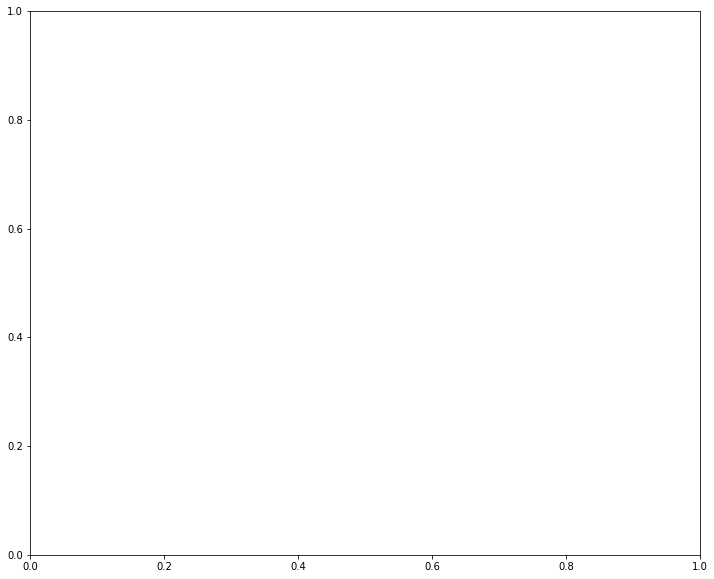

In [19]:
jval=100
irange=range(200,230)
fig = plt.figure(figsize=(12,10))

plt.pcolormesh(lon3d[:,jval,irange],z[:,jval,irange],temp[:,jval,irange],shading='faceted')
plt.title('Temperature Section along Adriatic, ocean_s_coordinate vertical coordinate');

In [20]:
!pip install cartopy
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
%matplotlib inline

import xarray as xr

In [21]:
ds = xr.open_dataset('ocean_avg_1161.nc', chunks={'ocean_time': 1})

In [22]:
ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])

In [23]:
variables = ['salt', 'zeta']
ds[variables].isel(ocean_time=slice(47, None, 7*24),
                   xi_rho=slice(300, None)).to_netcdf('ROMS_example.nc', mode='w')

In [24]:
ds

<xarray.Dataset>
Dimensions:        (eta_psi: 413, eta_rho: 414, eta_u: 414, eta_v: 413, ocean_time: 1, s_rho: 40, s_w: 41, tracer: 2, xi_psi: 423, xi_rho: 424, xi_u: 423, xi_v: 424)
Coordinates: (12/16)
    Vtransform     int32 ...
    hc             float64 ...
  * s_rho          (s_rho) float64 -0.9875 -0.9625 -0.9375 ... -0.0375 -0.0125
  * s_w            (s_w) float64 -1.0 -0.975 -0.95 -0.925 ... -0.05 -0.025 0.0
    Cs_r           (s_rho) float64 dask.array<chunksize=(40,), meta=np.ndarray>
    Cs_w           (s_w) float64 dask.array<chunksize=(41,), meta=np.ndarray>
    ...             ...
    lat_u          (eta_u, xi_u) float64 dask.array<chunksize=(414, 423), meta=np.ndarray>
    lon_v          (eta_v, xi_v) float64 dask.array<chunksize=(413, 424), meta=np.ndarray>
    lat_v          (eta_v, xi_v) float64 dask.array<chunksize=(413, 424), meta=np.ndarray>
    lon_psi        (eta_psi, xi_psi) float64 dask.array<chunksize=(413, 423), meta=np.ndarray>
    lat_psi        (eta_psi, xi_psi) float64 dask.array<chunksize=(413, 423), meta=np.ndarray>
  * ocean_time     (ocean_time) datetime64[ns] 2019-07-14T12:00:00
Dimensions without coordinates: eta_psi, eta_rho, eta_u, eta_v, tracer, xi_psi, xi_rho, xi_u, xi_v
Data variables: (12/62)
    ntimes         int32 ...
    ndtfast        int32 ...
    dt             float64 ...
    dtfast         float64 ...
    dstart         datetime64[ns] ...
    nHIS           int32 ...
    ...             ...
    ubar           (ocean_time, eta_u, xi_u) float32 dask.array<chunksize=(1, 414, 423), meta=np.ndarray>
    vbar           (ocean_time, eta_v, xi_v) float32 dask.array<chunksize=(1, 413, 424), meta=np.ndarray>
    u              (ocean_time, s_rho, eta_u, xi_u) float32 dask.array<chunksize=(1, 40, 414, 423), meta=np.ndarray>
    v              (ocean_time, s_rho, eta_v, xi_v) float32 dask.array<chunksize=(1, 40, 413, 424), meta=np.ndarray>
    temp           (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 40, 414, 424), meta=np.ndarray>
    salt           (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 40, 414, 424), meta=np.ndarray>
Attributes: (12/33)
    file:              ./aws/Output/ocean_avg_1161.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4
    type:              ROMS/TOMS nonlinear model averages file
    title:             North West Pacific
    rst_file:          ./aws/Output/ocean_rst.nc
    ...                ...
    compiler_command:  /usr/local/mpi/pgi/bin/mpif90
    compiler_flags:    -Kieee -O3 -Mfree
    tiling:            004x004
    history:           ROMS/TOMS, Version 3.7, Monday - August 9, 2021 - 12:3...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_cl...
    CPP_options:       NWP2, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFLUX, AN...

In [83]:
if ds.Vtransform == 1:
    Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
    z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
elif ds.Vtransform == 2:
    Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
    z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho

ds.coords['z_rho'] = z_rho.transpose()   # needing transpose seems to be an xarray bug

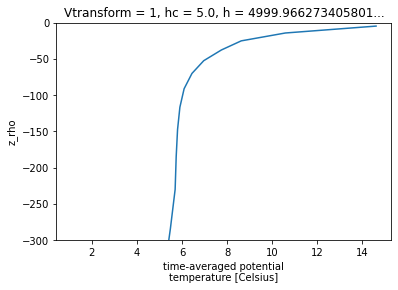

In [159]:
temp_sect=ds.temp.isel(xi_rho=350, eta_rho=300,ocean_time=0)
temp_sect.plot(y='z_rho') 
plt.ylim([-300,0]);
#temp_sect.dims
depth_temp=temp_sect.coords["z_rho"].values
depth_temp_value=temp_sect.values

In [162]:
temp_sect.coords["lon_rho"].values

array(153.88888889)

In [119]:
depth_temp
import pandas as pd

# Create the dataframe
depth_df = pd.DataFrame(depth_temp)
depth_temp_df=pd.DataFrame(depth_temp_value)

In [140]:
depth_df.columns=["Depth"]
depth_temp_df.columns=["Temp"]

In [148]:
result=pd.concat([depth_df,depth_temp_df],axis=1)
result
result=result.sort_values(by='Depth',ascending=False)

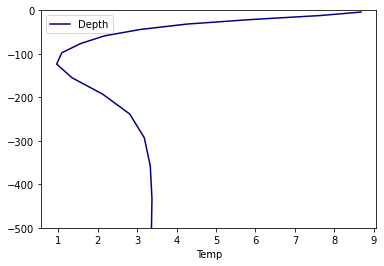

In [153]:
result.plot(x='Temp', y='Depth',style='-',c='DarkBlue')
plt.ylim([-500,0]);

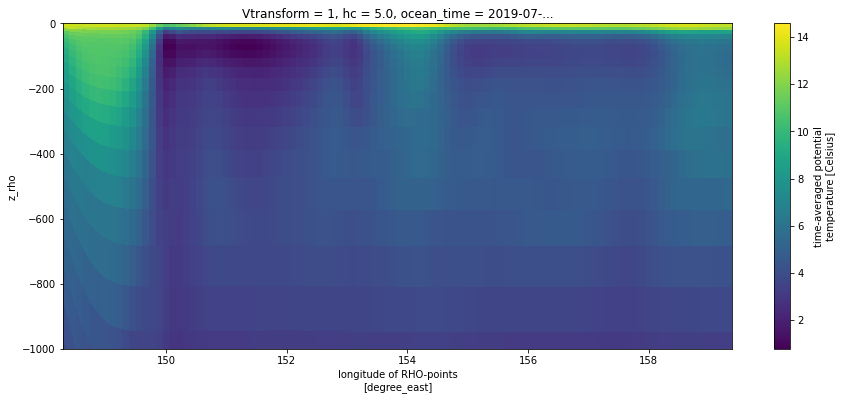

In [87]:
section = ds.temp.isel(xi_rho=slice(300,400), eta_rho=300, ocean_time=0)
section.plot(x='lon_rho', y='z_rho', figsize=(15, 6), clim=(25, 35),linestyle='dashed')
plt.ylim([-1000, 1]);

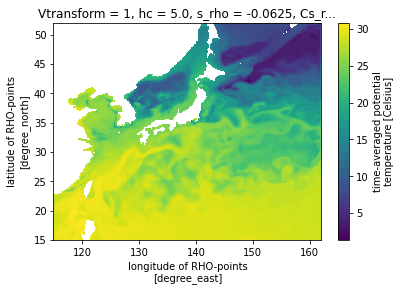

In [54]:
ds.temp.isel(s_rho=-3, ocean_time=0).plot(x='lon_rho', y='lat_rho')

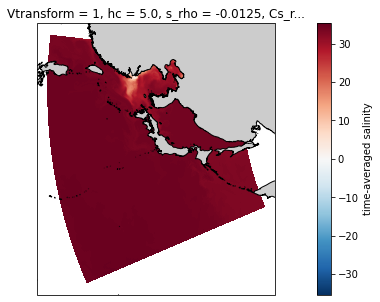

In [55]:
proj = ccrs.LambertConformal(central_longitude=-92, central_latitude=29)
fig = plt.figure(figsize=(15, 5))
ax = plt.axes(projection=proj)
ds.salt.isel(s_rho=-1, ocean_time=0).plot(x='lon_rho', y='lat_rho',
                                          transform=ccrs.PlateCarree())

coast_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='k', facecolor='0.8')
ax.add_feature(coast_10m)